In [1]:
%load_ext autoreload
%autoreload 2

curr_dir = '/user_data/vayzenbe/GitHub_Repos/goodale-milner-dnns'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pdb


sys.path.append('DeepDive')
sys.path.append('CORnet')
from deepdive.feature_extraction import get_empty_feature_maps, StimulusSet, get_all_feature_maps



import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11


from sklearn.model_selection import StratifiedShuffleSplit,RepeatedStratifiedKFold, StratifiedGroupKFold

from sklearn import svm

import warnings
warnings.filterwarnings('ignore')


/home/vayzenbe/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_suf = ''

splits = 20

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']

transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
#                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
            ])

In [3]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='cornet_s':
        model = cornet.get_model('s', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        
    return model

In [4]:
def get_loader(stim_dir):
    test_dataset =torchvision.datasets.ImageFolder(stim_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 2, pin_memory=True)
    return testloader, test_dataset


In [5]:
def plot_all_models(model_df,exp_name,file_suf=''):

    model_df['model layer'] = [f'{model}        {layer}' for model, layer in zip(model_df['model'], model_df['layer'])]
    fig = plt.figure(figsize=(25,5))
    ax = sns.barplot(data = model_df, x='model layer', hue='model', y='accuracy',dodge=False )
    ax.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim(0, 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #set yaxis interval to .25
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    plt.legend().remove()
    #increase font size of y axis labels
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
    #change y axis title to accuracy
    ax.set_ylabel('Accuracy', fontsize=16)

    plt.title(exp_name, fontsize = 16)
    
    #     plt.tight_layout()
    plt.savefig(f'figures/models_{exp_name}_acc{file_suf}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:



testloader, test_dataset = get_loader(f'{curr_dir}/stim/rect_rot')

## print out named layers for each model
for model_arch in models:
    print(model_arch+ '\n')
    model_layers = get_empty_feature_maps(load_model(model_arch), testloader, names_only = True)
    print(model_layers)
    print('\n')

alexnet

['Conv2d-1', 'ReLU-1', 'MaxPool2d-1', 'Conv2d-2', 'ReLU-2', 'MaxPool2d-2', 'Conv2d-3', 'ReLU-3', 'Conv2d-4', 'ReLU-4', 'Conv2d-5', 'ReLU-5', 'MaxPool2d-3', 'Linear-1', 'ReLU-6', 'Linear-2', 'ReLU-7', 'Linear-3']


vgg19

['Conv2d-1', 'ReLU-1', 'Conv2d-2', 'ReLU-2', 'MaxPool2d-1', 'Conv2d-3', 'ReLU-3', 'Conv2d-4', 'ReLU-4', 'MaxPool2d-2', 'Conv2d-5', 'ReLU-5', 'Conv2d-6', 'ReLU-6', 'Conv2d-7', 'ReLU-7', 'Conv2d-8', 'ReLU-8', 'MaxPool2d-3', 'Conv2d-9', 'ReLU-9', 'Conv2d-10', 'ReLU-10', 'Conv2d-11', 'ReLU-11', 'Conv2d-12', 'ReLU-12', 'MaxPool2d-4', 'Conv2d-13', 'ReLU-13', 'Conv2d-14', 'ReLU-14', 'Conv2d-15', 'ReLU-15', 'Conv2d-16', 'ReLU-16', 'MaxPool2d-5', 'Linear-1', 'ReLU-17', 'Linear-2', 'ReLU-18', 'Linear-3']


resnet18

['Conv2d-1', 'BatchNorm2d-1', 'ReLU-1', 'MaxPool2d-1', 'Conv2d-2', 'BatchNorm2d-2', 'ReLU-2', 'Conv2d-3', 'BatchNorm2d-3', 'ReLU-3', 'Conv2d-4', 'BatchNorm2d-4', 'ReLU-4', 'Conv2d-5', 'BatchNorm2d-5', 'ReLU-5', 'Conv2d-6', 'BatchNorm2d-6', 'ReLU-6', 'Conv2d-

# Classification accuracy

In [8]:
from sklearn.linear_model import RidgeClassifierCV



def classify_2way(acts, labels, splits):
    acc = []
    for label_pair in itertools.combinations(np.unique(labels), 2):
        sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.333)
        #run classifier
    #         these_accs = []
        inds = np.argwhere([label in label_pair for label in labels])
        for i, (train_index, test_index) in enumerate(sss.split(acts[inds], labels[inds])):
            X_train, X_test = acts[inds][train_index], acts[inds][test_index]
            y_train, y_test = labels[inds][train_index], labels[inds][test_index]

            
            #clf = svm.SVC()
            clf = RidgeClassifierCV()
            clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
            acc.append(clf.score(X_test.reshape(X_test.shape[0],-1), y_test))
    #         acc.append(np.mean(these_accs))

    return np.array(acc)



  0%|          | 0/5 [00:00<?, ?it/s]

alexnet


 20%|██        | 1/5 [00:13<00:52, 13.23s/it]

vgg19


 40%|████      | 2/5 [10:47<18:55, 378.36s/it]

resnet18


 60%|██████    | 3/5 [11:43<07:42, 231.14s/it]

cornet_z


 80%|████████  | 4/5 [12:13<02:31, 151.70s/it]

cornet_s


100%|██████████| 5/5 [15:26<00:00, 185.25s/it]


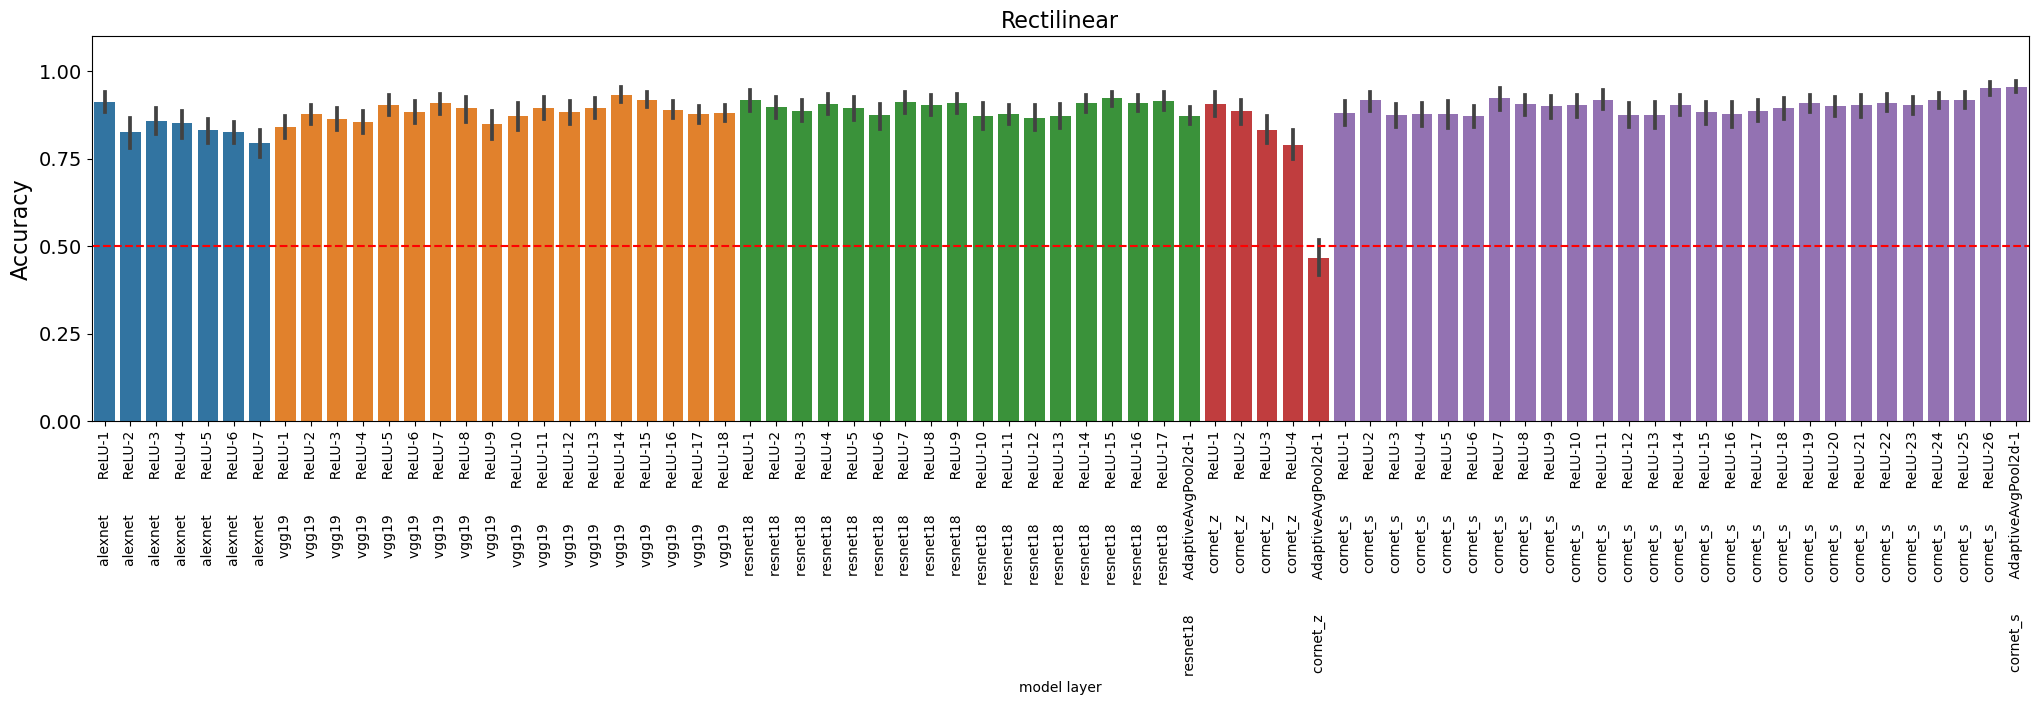

  0%|          | 0/5 [00:00<?, ?it/s]

alexnet


 20%|██        | 1/5 [00:16<01:04, 16.11s/it]

vgg19


 40%|████      | 2/5 [10:50<18:59, 379.78s/it]

resnet18


 60%|██████    | 3/5 [11:51<07:48, 234.03s/it]

cornet_z


 80%|████████  | 4/5 [12:25<02:35, 155.19s/it]

cornet_s


100%|██████████| 5/5 [15:56<00:00, 191.39s/it]


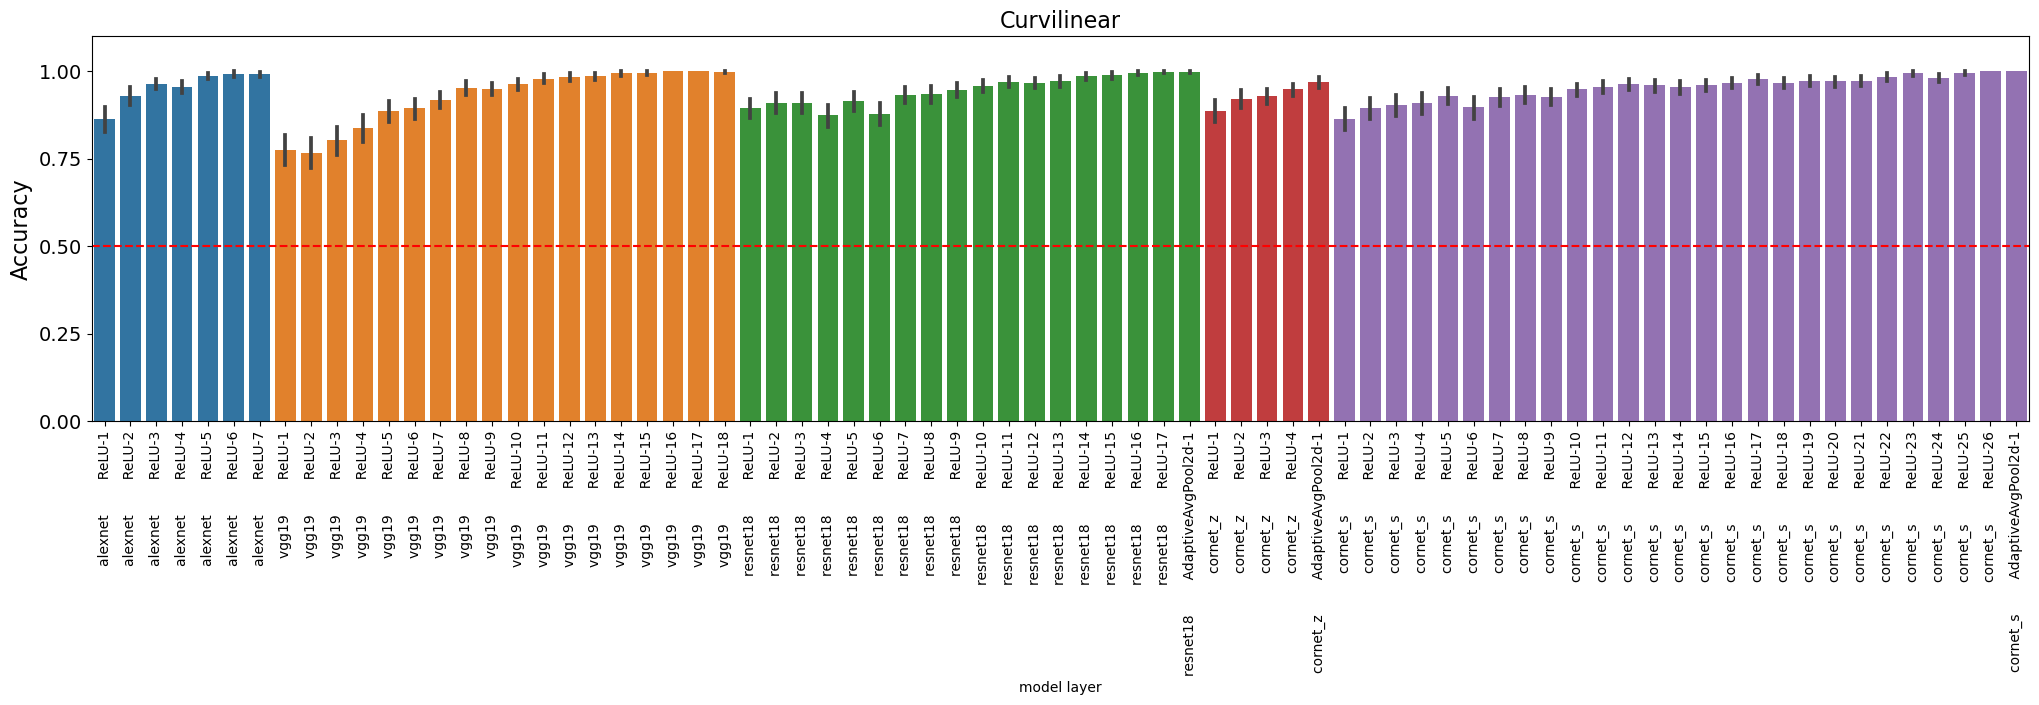

In [9]:
'''
Discriminate rotated stim
'''
from tqdm import tqdm
import itertools


condition = 'rot'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[])
    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        print(model_arch)
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')

    #     acts = extract_acts(model, stim_dir, transform, layer_call)
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)
        for layer in tqdm(layers):
            acts = activations[layer]

            accs = classify_2way(acts, labels, splits)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)



    model_df = pd.DataFrame(model_df)
    model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}_ridge.csv')

    plot_all_models(model_df,exp_name)


  0%|          | 0/5 [00:00<?, ?it/s]

alexnet


 20%|██        | 1/5 [00:15<01:00, 15.15s/it]

vgg19


 40%|████      | 2/5 [10:31<18:25, 368.57s/it]

resnet18


 60%|██████    | 3/5 [11:39<07:42, 231.41s/it]

cornet_z


 80%|████████  | 4/5 [12:08<02:31, 151.50s/it]

cornet_s


100%|██████████| 5/5 [15:00<00:00, 180.13s/it]


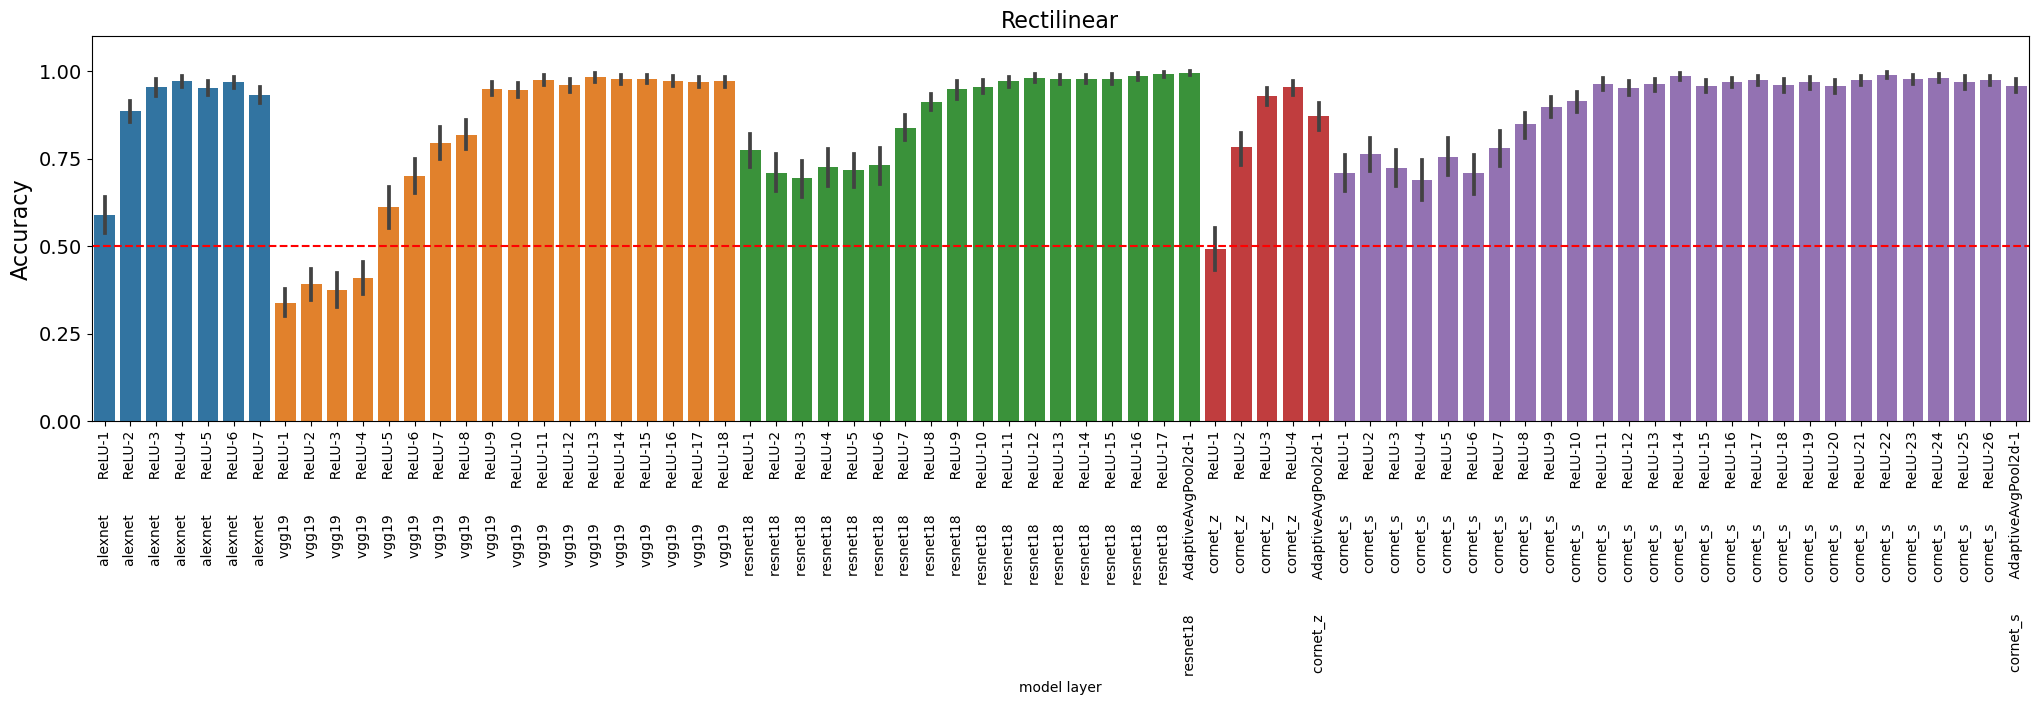

  0%|          | 0/5 [00:00<?, ?it/s]

alexnet


 20%|██        | 1/5 [00:16<01:06, 16.53s/it]

vgg19


 40%|████      | 2/5 [10:23<18:12, 364.02s/it]

resnet18


 60%|██████    | 3/5 [11:14<07:21, 220.73s/it]

cornet_z


 80%|████████  | 4/5 [11:51<02:28, 148.28s/it]

cornet_s


100%|██████████| 5/5 [14:53<00:00, 178.74s/it]


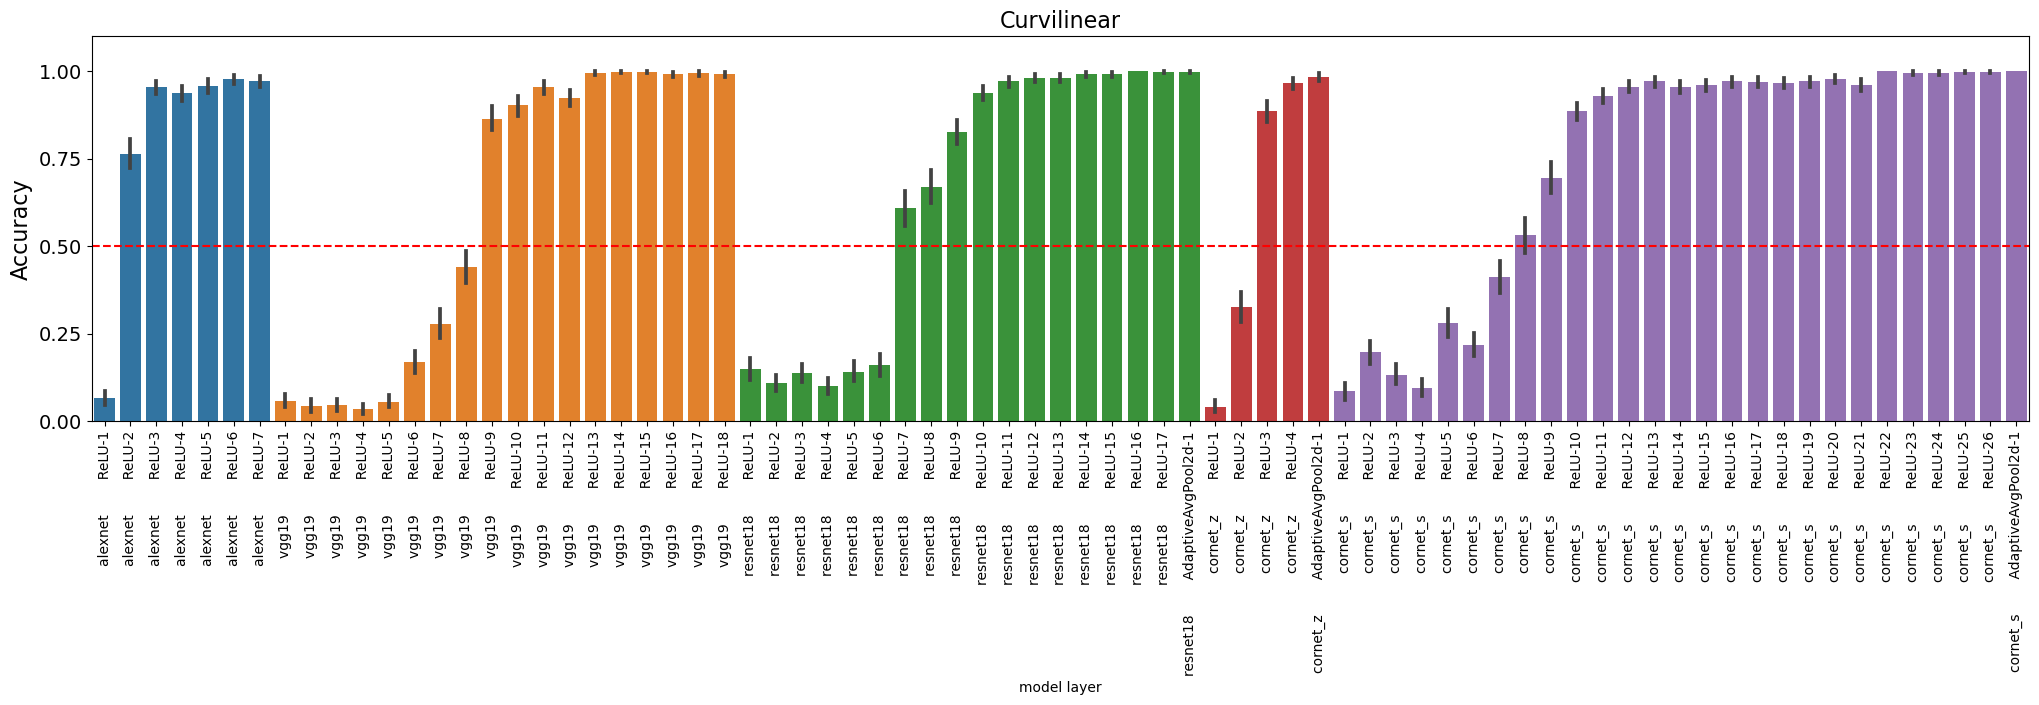

In [10]:
'''
Discriminate size stim
'''
from tqdm import tqdm
import itertools


condition = 'scale'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[])
    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        print(model_arch)
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')

    #     acts = extract_acts(model, stim_dir, transform, layer_call)
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)
        for layer in tqdm(layers):
            acts = activations[layer]

            accs = classify_2way(acts, labels, splits)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)



    model_df = pd.DataFrame(model_df)
    model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}_ridge.csv')

    plot_all_models(model_df,exp_name)


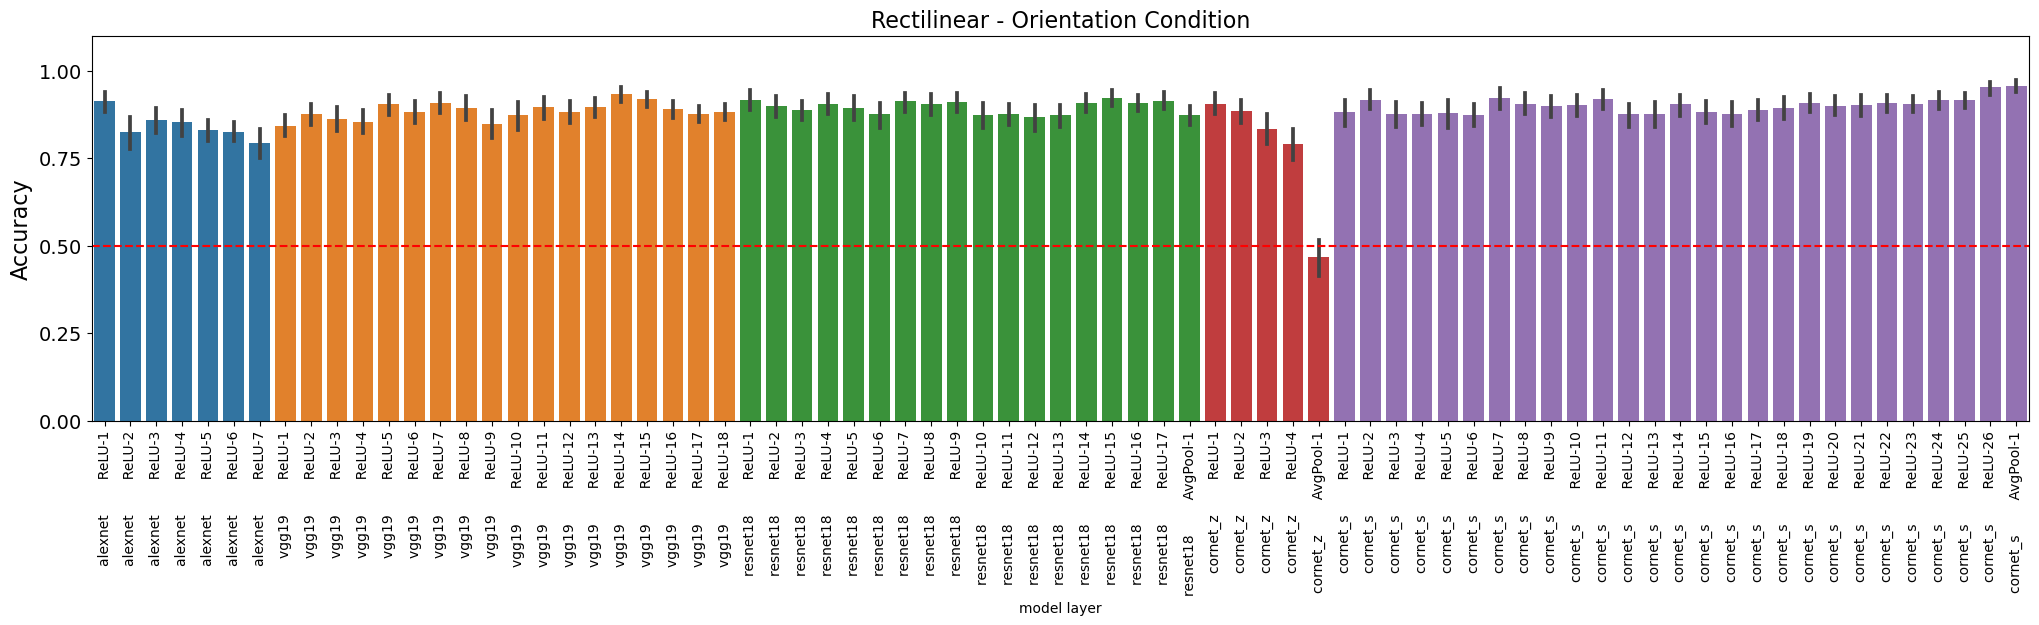

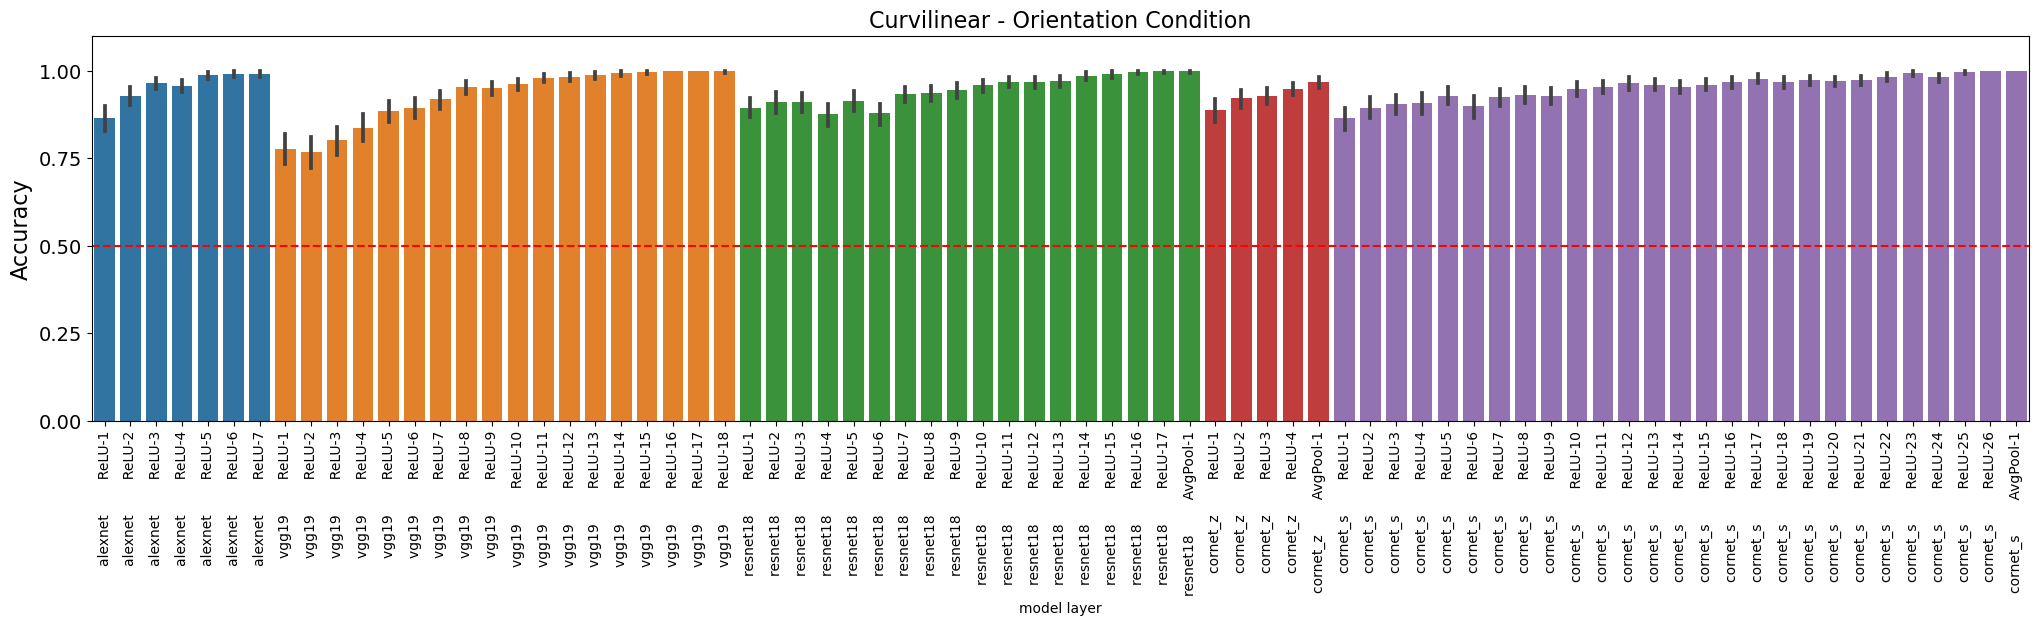

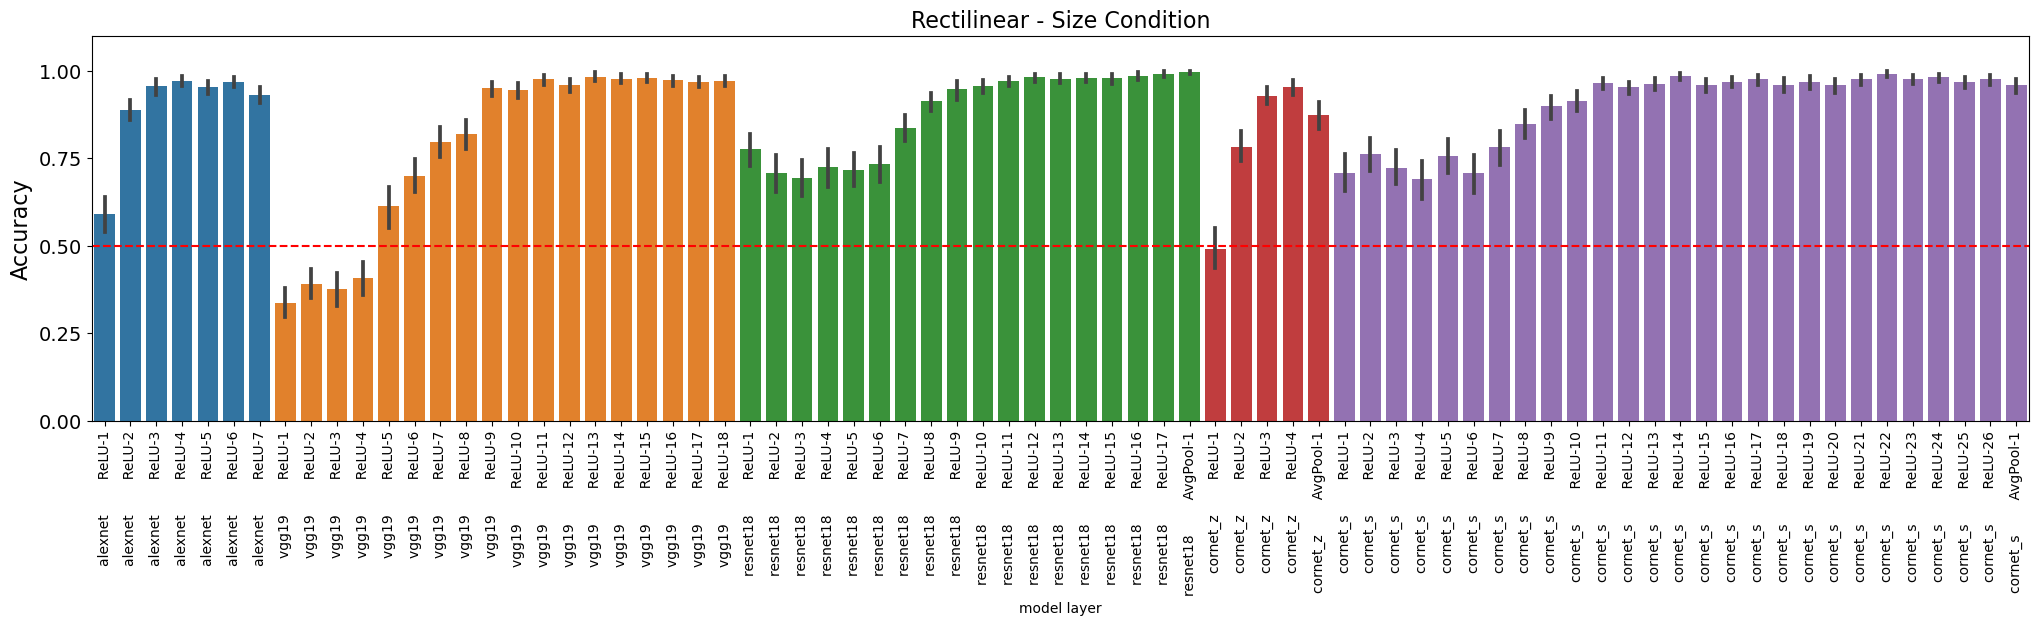

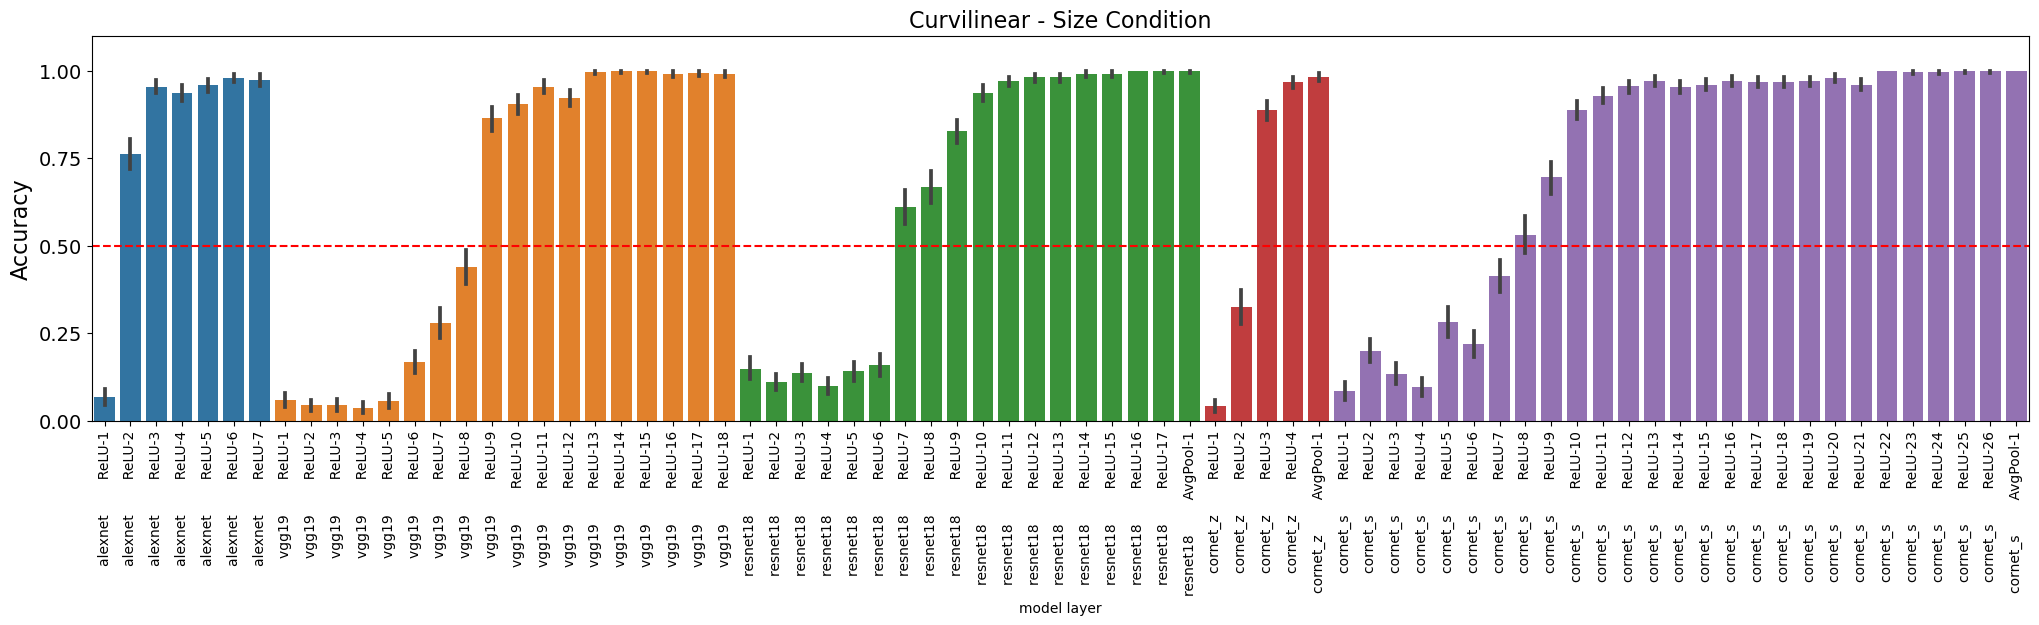

In [6]:
condition = '_rot'
df = pd.read_csv(f'results/Rectilinear_acc{condition}_ridge.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Rectilinear - Orientation Condition', f'_{condition}_ridge')

df = pd.read_csv(f'results/Curvilinear_acc{condition}_ridge.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Curvilinear - Orientation Condition', f'_{condition}_ridge')


condition = '_scale'
df = pd.read_csv(f'results/Rectilinear_acc{condition}_ridge.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Rectilinear - Size Condition', f'_{condition}_ridge')

df = pd.read_csv(f'results/Curvilinear_acc{condition}_ridge.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Curvilinear - Size Condition', f'_{condition}_ridge')
